In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import import_ipynb
from helpers import train_and_validate, count_parameters, plot_loss_comparison, plot_test_predictions, compare_mse_loss
import time
import matplotlib.pyplot as plt

importing Jupyter notebook from helpers.ipynb


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
window_size = 24
batch_size = 100
input_size = 1
hidden_size = 100
num_classes = 1
learning_rate = 0.001
epochs = 200
criterion = nn.MSELoss()

In [4]:
def root_mean_squared_error(actual, predicted):
    actual = torch.tensor(actual, dtype=torch.float32)
    predicted = torch.tensor(predicted, dtype=torch.float32)
    
    if actual.shape != predicted.shape:
        raise ValueError("Tensors must have the same shape.")
    
    mse = torch.mean((actual - predicted)**2)
    
    return (mse.item() ** 0.5)

In [5]:
df = pd.read_csv("./data/clean_data.csv")
df = df[:-24]
df.shape

(15955, 5)

In [6]:
df = df[["Date", "P (kW)"]]
train_df = df.iloc[:-24]
test = df.iloc[-24:]

In [7]:
def prepare_dataframe(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'P (kW)(t-{i})'] = df['P (kW)'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

In [8]:
new_df = prepare_dataframe(train_df, window_size)
new_df = new_df.to_numpy()
new_df

array([[  0.        ,   0.        ,   0.        , ...,  14.75265   ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ..., 127.16308333,
         14.75265   ,   0.        ],
       [ 16.82213636,   0.        ,   0.        , ..., 302.4557    ,
        127.16308333,  14.75265   ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [9]:
new_df.shape

(15907, 25)

In [10]:
X = new_df[:, 1:]
y = new_df[:, 0]

In [11]:
X.shape, y.shape

((15907, 24), (15907,))

In [12]:
split_index = int(len(X) * 0.9)

In [13]:
X_train = X[:split_index]
X_val = X[split_index:]

y_train = y[:split_index]
y_val = y[split_index:]

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((14316, 24), (1591, 24), (14316,), (1591,))

In [14]:
X_train = X_train.reshape((-1, window_size, 1))
X_val = X_val.reshape((-1, window_size, 1))

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((14316, 24, 1), (1591, 24, 1), (14316, 1), (1591, 1))

In [15]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()

X_train.shape, X_val.shape, y_train.shape, y_val.shape

(torch.Size([14316, 24, 1]),
 torch.Size([1591, 24, 1]),
 torch.Size([14316, 1]),
 torch.Size([1591, 1]))

In [16]:
class SolarData(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [17]:
train = SolarData(X_train, y_train)
val = SolarData(X_val, y_val)

In [18]:
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val, batch_size = batch_size, shuffle = False)

In [19]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([100, 24, 1]) torch.Size([100, 1])


## RNN

In [20]:
class RNNNet(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.rnn_layer = nn.RNN(input_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, hidden = self.rnn_layer(x)
        out = self.fc(out[:, -1, :])
        return out

In [21]:
rnnnet = RNNNet(input_size, hidden_size, num_classes).to(device)
rnnnet_optimizer = torch.optim.Adam(rnnnet.parameters(), lr = learning_rate)

In [22]:
total_rnnnet_parameters = count_parameters(rnnnet)

In [23]:
rnnnet_train_loss_array = []
rnnnet_val_loss_array = []

In [24]:
rnnnet_start_time = time.time()
train_and_validate(epochs, device, rnnnet, train_loader, val_loader, criterion, rnnnet_optimizer, rnnnet_train_loss_array, rnnnet_val_loss_array)
rnnnet_end_time = time.time()
rnnnet_total_training_time = rnnnet_end_time - rnnnet_start_time
rnnnet_avg_training_time_per_epoch = rnnnet_total_training_time / epochs

Epoch no.: 1 | Training Loss: 84468.775390625 | Validation Loss: 25738.94207763672
Epoch no.: 2 | Training Loss: 80027.82264539931 | Validation Loss: 23946.364013671875
Epoch no.: 3 | Training Loss: 75893.22216796875 | Validation Loss: 22148.573516845703
Epoch no.: 4 | Training Loss: 71557.27989366319 | Validation Loss: 20754.981201171875
Epoch no.: 5 | Training Loss: 67739.73319498698 | Validation Loss: 19093.329528808594
Epoch no.: 6 | Training Loss: 64482.45600043403 | Validation Loss: 17721.619430541992
Epoch no.: 7 | Training Loss: 60998.79154459635 | Validation Loss: 16619.646560668945
Epoch no.: 8 | Training Loss: 57786.446261935766 | Validation Loss: 15397.082946777344
Epoch no.: 9 | Training Loss: 54899.89774576823 | Validation Loss: 14502.965408325195
Epoch no.: 10 | Training Loss: 52187.36446126302 | Validation Loss: 13624.704711914062
Epoch no.: 11 | Training Loss: 49891.21560329861 | Validation Loss: 13420.325134277344
Epoch no.: 12 | Training Loss: 47828.46457248264 | Val

In [25]:
print()
print()
print("------------------------------------------------------------")
print(f"Total Parameters:     RNN: {total_rnnnet_parameters}")
print()
print(f"Total Training Time:     RNN: {rnnnet_total_training_time:.2f}s")
print()
print(f"Average Training Time Per Epoch:     RNN: {rnnnet_avg_training_time_per_epoch:.2f}s")

print("------------------------------------------------------------")



------------------------------------------------------------
Total Parameters:     RNN: 10401

Total Training Time:     RNN: 126.40s

Average Training Time Per Epoch:     RNN: 0.63s
------------------------------------------------------------


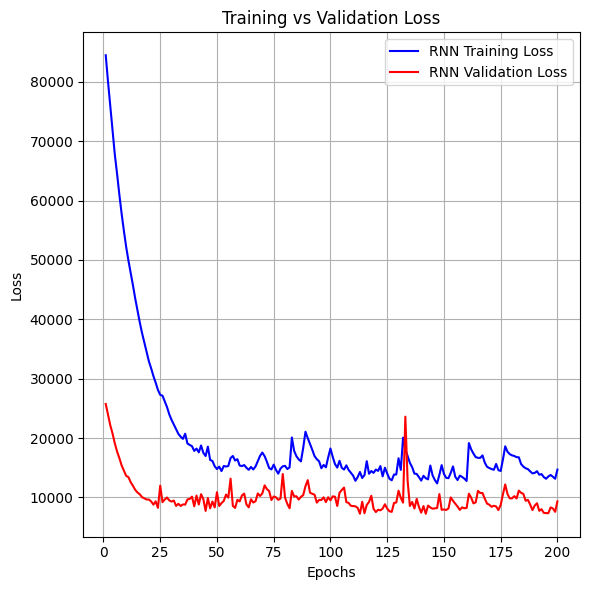

In [26]:
plot_loss_comparison(epochs, rnnnet_train_loss_array, rnnnet_val_loss_array, "RNN Training Loss", "RNN Validation Loss", "Training vs Validation Loss")

In [27]:
rnnnet.eval()
last_24_values_test = y_val[-window_size:]
last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)
predictions_test = []

for i in range(window_size):
    # Make the prediction
    with torch.no_grad():
        pred_test = rnnnet(last_24_values_test)
    
    # Store the prediction
    predictions_test.append(pred_test.item())
    
    # Shift the values to the left and add the predicted value to the last_24_values_test for the next iteration
    last_24_values_test = torch.cat((last_24_values_test[:, 1:], pred_test.unsqueeze(1)), dim=1)

# Convert predictions_test to a numpy array
predictions_test = np.array(predictions_test)

C:\Users\itadmin\AppData\Local\Temp\ipykernel_14428\1549511991.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)


In [28]:
window_size

24

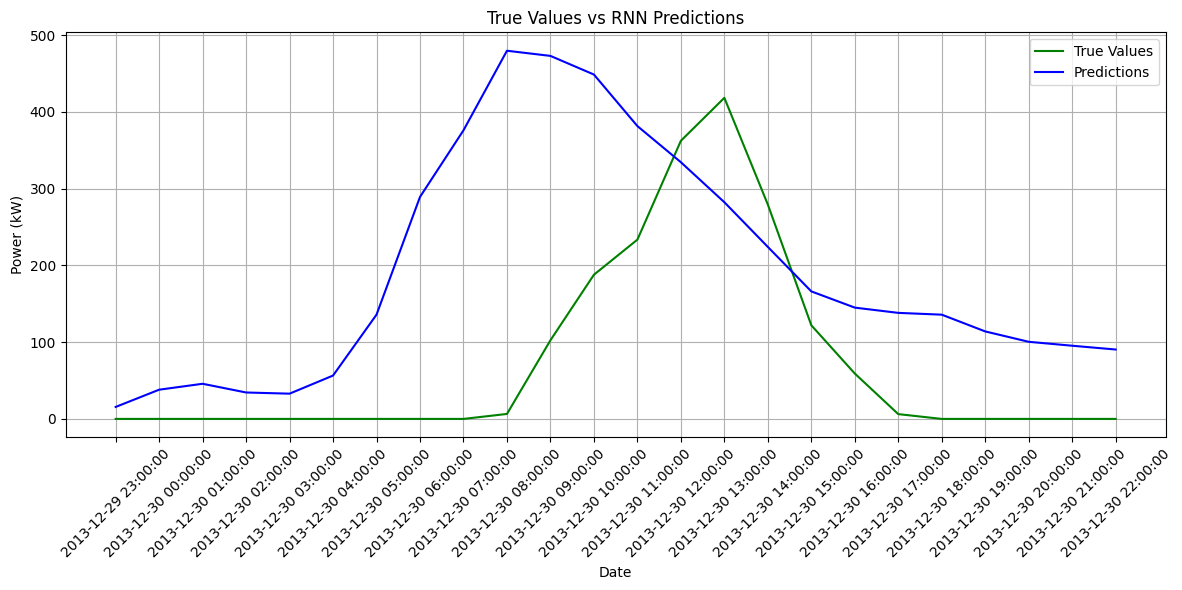

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['P (kW)'], 'g', label='True Values')
plt.plot(test['Date'], predictions_test, 'b', label='Predictions')
plt.title('True Values vs RNN Predictions')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
rmse = root_mean_squared_error(test["P (kW)"].values, predictions_test)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 183.84459724860017


## LSTM

In [31]:
class LSTMNet(nn.Module):

    def __init__(self, input_size: int, hidden_size: int, num_classes: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x_, (h_t, c_t) = self.lstm(x)
        out = self.fc(x_[:, -1, :])
        return out

In [32]:
lstmnet = LSTMNet(input_size, hidden_size, num_classes).to(device)
lstmnet_optimizer = torch.optim.Adam(lstmnet.parameters(), lr = learning_rate)

In [33]:
total_lstmnet_parameters = count_parameters(lstmnet)

In [34]:
lstmnet_train_loss_array = []
lstmnet_val_loss_array = []

In [35]:
lstmnet_start_time = time.time()
train_and_validate(epochs, device, lstmnet, train_loader, val_loader, criterion, lstmnet_optimizer, lstmnet_train_loss_array, lstmnet_val_loss_array)
lstmnet_end_time = time.time()
lstmnet_total_training_time = lstmnet_end_time - lstmnet_start_time
lstmnet_avg_training_time_per_epoch = lstmnet_total_training_time / epochs

Epoch no.: 1 | Training Loss: 84284.19314236111 | Validation Loss: 25332.140197753906
Epoch no.: 2 | Training Loss: 78485.30910915798 | Validation Loss: 23289.274154663086
Epoch no.: 3 | Training Loss: 73910.22667100694 | Validation Loss: 21500.81768798828
Epoch no.: 4 | Training Loss: 70081.53746202256 | Validation Loss: 20022.15219116211
Epoch no.: 5 | Training Loss: 66063.1695014106 | Validation Loss: 17622.65852355957
Epoch no.: 6 | Training Loss: 62107.659478081594 | Validation Loss: 16345.495803833008
Epoch no.: 7 | Training Loss: 58311.28404405382 | Validation Loss: 14864.226501464844
Epoch no.: 8 | Training Loss: 55289.96705457899 | Validation Loss: 13448.920272827148
Epoch no.: 9 | Training Loss: 51845.97677951389 | Validation Loss: 12313.539962768555
Epoch no.: 10 | Training Loss: 49206.65158420139 | Validation Loss: 11283.134857177734
Epoch no.: 11 | Training Loss: 46570.05072699653 | Validation Loss: 11049.950927734375
Epoch no.: 12 | Training Loss: 44337.77986653646 | Vali

In [36]:
print()
print()
print("------------------------------------------------------------")
print(f"Total Parameters:     LSTM: {total_lstmnet_parameters}")
print()
print(f"Total Training Time:     LSTM: {lstmnet_total_training_time:.2f}s")
print()
print(f"Average Training Time Per Epoch:     LSTM: {lstmnet_avg_training_time_per_epoch:.2f}s")

print("------------------------------------------------------------")



------------------------------------------------------------
Total Parameters:     LSTM: 41301

Total Training Time:     LSTM: 217.92s

Average Training Time Per Epoch:     LSTM: 1.09s
------------------------------------------------------------


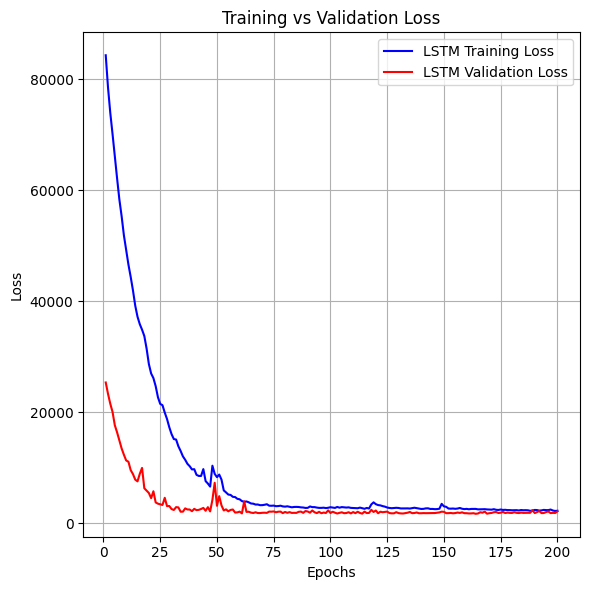

In [37]:
plot_loss_comparison(epochs, lstmnet_train_loss_array, lstmnet_val_loss_array, "LSTM Training Loss", "LSTM Validation Loss", "Training vs Validation Loss")

In [38]:
lstmnet.eval()
last_24_values_test = y_val[-window_size:]
last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)
predictions_test = []

for i in range(window_size):
    # Make the prediction
    with torch.no_grad():
        pred_test = lstmnet(last_24_values_test)
    
    # Store the prediction
    predictions_test.append(pred_test.item())
    
    # Shift the values to the left and add the predicted value to the last_24_values_test for the next iteration
    last_24_values_test = torch.cat((last_24_values_test[:, 1:], pred_test.unsqueeze(1)), dim=1)

# Convert predictions_test to a numpy array
predictions_test = np.array(predictions_test)

C:\Users\itadmin\AppData\Local\Temp\ipykernel_14428\22171312.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)


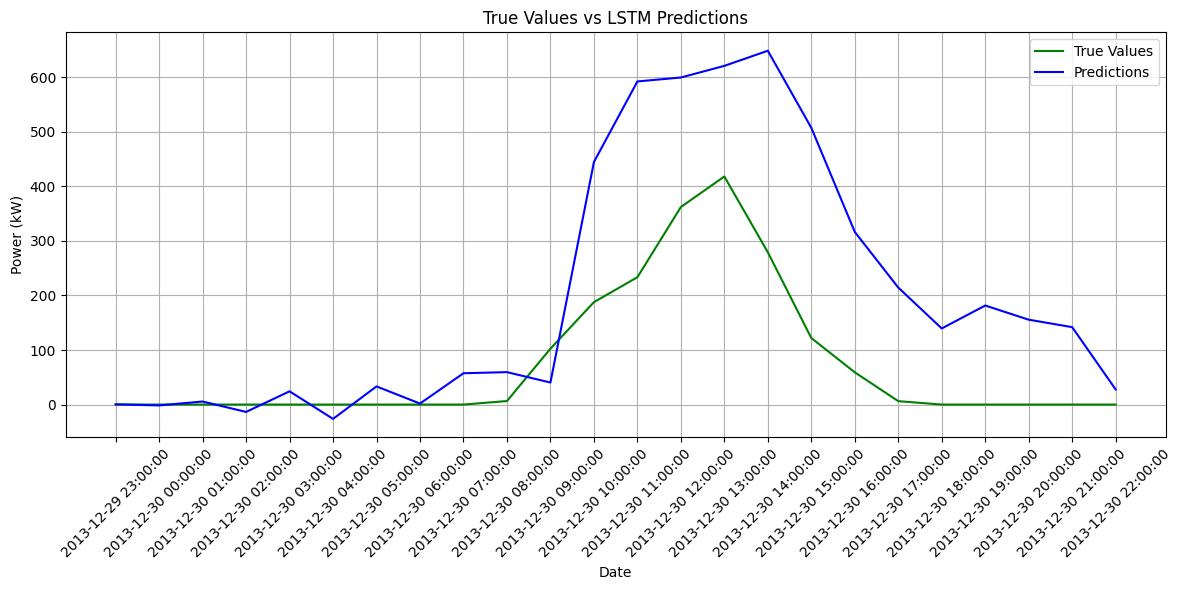

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['P (kW)'], 'g', label='True Values')
plt.plot(test['Date'], predictions_test, 'b', label='Predictions')
plt.title('True Values vs LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
rmse = root_mean_squared_error(test["P (kW)"].values, predictions_test)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 182.29919389221115


## GRU 

In [41]:
class GRUNet(nn.Module):

    def __init__(self, input_size: int, hidden_size: int, num_classes: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.gru = nn.GRU(input_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x_, h = self.gru(x)
        out = self.fc(x_[:, -1, :])
        return out

In [42]:
grunet = LSTMNet(input_size, hidden_size, num_classes).to(device)
grunet_optimizer = torch.optim.Adam(grunet.parameters(), lr = learning_rate)

In [43]:
total_grunet_parameters = count_parameters(grunet)

In [44]:
grunet_train_loss_array = []
grunet_val_loss_array = []

In [45]:
grunet_start_time = time.time()
train_and_validate(epochs, device, grunet, train_loader, val_loader, criterion, grunet_optimizer, grunet_train_loss_array, grunet_val_loss_array)
grunet_end_time = time.time()
grunet_total_training_time = grunet_end_time - grunet_start_time
grunet_avg_training_time_per_epoch = grunet_total_training_time / epochs

Epoch no.: 1 | Training Loss: 85019.23090277778 | Validation Loss: 25609.680725097656
Epoch no.: 2 | Training Loss: 79662.99669053819 | Validation Loss: 23774.884887695312
Epoch no.: 3 | Training Loss: 75288.1494954427 | Validation Loss: 21979.79833984375
Epoch no.: 4 | Training Loss: 71173.15435112847 | Validation Loss: 19971.28204345703
Epoch no.: 5 | Training Loss: 67134.35956488716 | Validation Loss: 18310.443481445312
Epoch no.: 6 | Training Loss: 63260.082980685766 | Validation Loss: 16805.542724609375
Epoch no.: 7 | Training Loss: 60019.57777235243 | Validation Loss: 15332.014831542969
Epoch no.: 8 | Training Loss: 56544.24206542969 | Validation Loss: 14103.01205444336
Epoch no.: 9 | Training Loss: 53388.79336208767 | Validation Loss: 12825.120788574219
Epoch no.: 10 | Training Loss: 50768.995144314234 | Validation Loss: 12043.912628173828
Epoch no.: 11 | Training Loss: 47651.7158610026 | Validation Loss: 10946.267623901367
Epoch no.: 12 | Training Loss: 45116.86564127604 | Vali

In [46]:
print()
print()
print("------------------------------------------------------------")
print(f"Total Parameters:     GRU: {total_grunet_parameters}")
print()
print(f"Total Training Time:     GRU: {grunet_total_training_time:.2f}s")
print()
print(f"Average Training Time Per Epoch:     GRU: {grunet_avg_training_time_per_epoch:.2f}s")

print("------------------------------------------------------------")



------------------------------------------------------------
Total Parameters:     GRU: 41301

Total Training Time:     GRU: 162.82s

Average Training Time Per Epoch:     GRU: 0.81s
------------------------------------------------------------


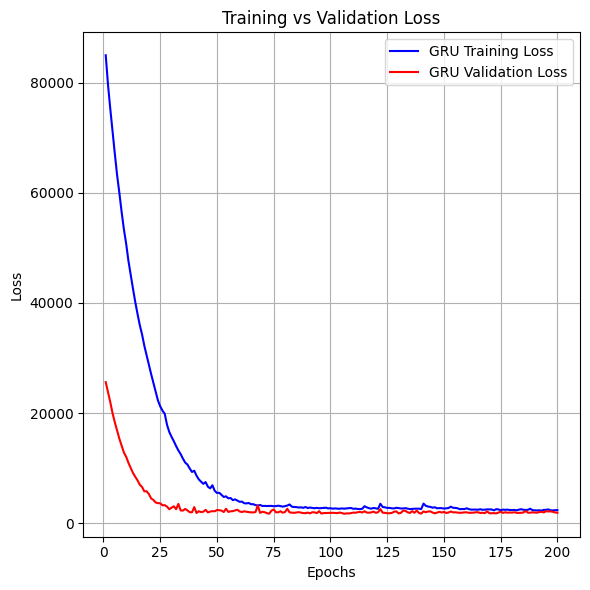

In [47]:
plot_loss_comparison(epochs, grunet_train_loss_array, grunet_val_loss_array, "GRU Training Loss", "GRU Validation Loss", "Training vs Validation Loss")

In [48]:
grunet.eval()
last_24_values_test = y_val[-window_size:]
last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)
predictions_test = []

for i in range(window_size):
    # Make the prediction
    with torch.no_grad():
        pred_test = grunet(last_24_values_test)
    
    # Store the prediction
    predictions_test.append(pred_test.item())
    
    # Shift the values to the left and add the predicted value to the last_24_values_test for the next iteration
    last_24_values_test = torch.cat((last_24_values_test[:, 1:], pred_test.unsqueeze(1)), dim=1)

# Convert predictions_test to a numpy array
predictions_test = np.array(predictions_test)

C:\Users\itadmin\AppData\Local\Temp\ipykernel_14428\1542476720.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)


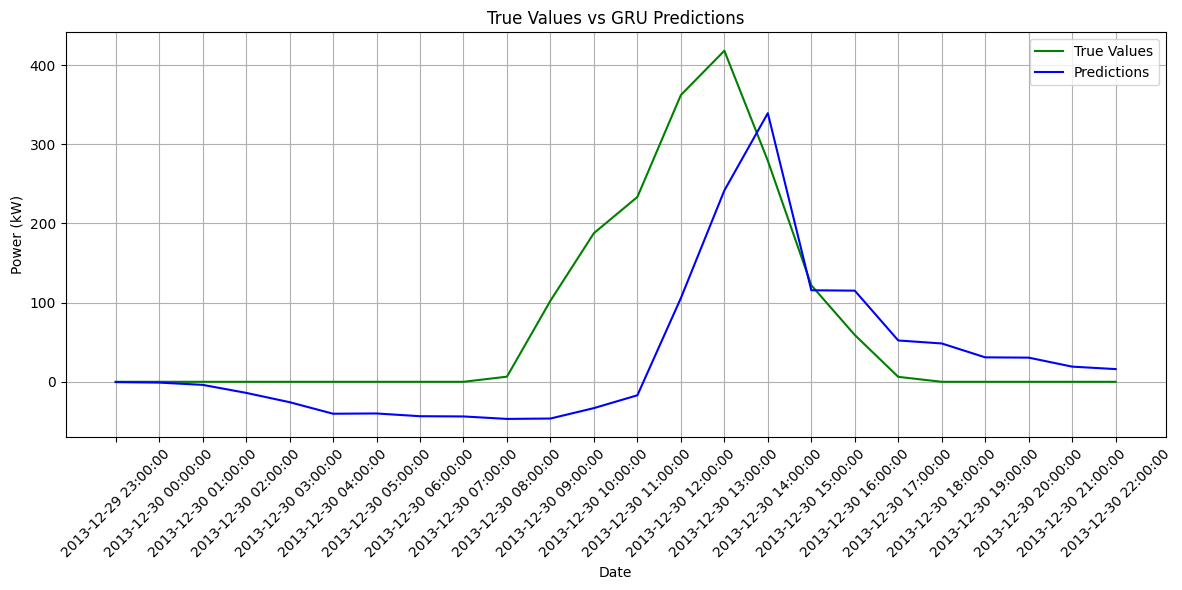

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['P (kW)'], 'g', label='True Values')
plt.plot(test['Date'], predictions_test, 'b', label='Predictions')
plt.title('True Values vs GRU Predictions')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
rmse = root_mean_squared_error(test["P (kW)"].values, predictions_test)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 103.12853687116626
